## Chapter 4 [Spectroscopy](Ch4-Spectroscopy.ipynb)


<hr style="height:1px;border-top:4px solid #FF8200" />

# EDS Detector Efficiency 


part of 

## [Analysis of Scanning Electron Microscope Data](_Analysis_of_Scanning_Electron_Microscope_Data.ipynb)



by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with scanning electron microscopes

## First we import the essential libraries
All we need here should come with the annaconda or any other package

In [2]:
#import matplotlib and numpy with a magic comand
%pylab --no-import-all notebook

import pickle ## to read photoabsorption data

Populating the interactive namespace from numpy and matplotlib


## Bremsstrahlung and EDS Background

At low energies,  the [Bremsstrahlung](Ch4-Bremsstrahlung.ipynb) above does not look anything like the background we obtain in the EDS spectrum.

This is due to the  response of the EDS detector system

![X-Ray_Auger](./images_SEM/DetectorEfficiency.png).


## Detector Response

The detector response depends on the material. The detected X-ray photons need to be absorbed in the Si detector. This absorption is then dependent on the silicon aborption coefficients (per energy).
Everything that absorbs X-ray photons before it reaches the detector crystal will weken the signal according to the photoabsorption in that material layers. Obviously we want to keep the thicknesses of those layers as thin as possible.

Let's look at the design of a detector:

![detector overview](images_SEM/Bruker3b.jpg)

![detector details](images_SEM/Bruker.jpg)

For the detector there is actually only one type common anymore (the liquid notrogen cooled Si(Li) detectors are phased out) and that is the Silicon droft detector (SDD):

![detector crystal](images_SEM/SDD2.jpg)

In front of the detector is usually a window. Only high vacuum system can have a window-less system otherwise ice would build up on the Peltier-cooled detector crystal.
This window is rather fragile and relative expensive to replace so be carfull with handling the detector system on that end.


![detector window](images_EDS/Window2.jpg)

## Detector Efficiency
### Photoabsorption 
If we only look at the crystal we see that we have a contact and the Silicon crystal. However there is also a thin deadlayer on the top of the crystal that will absorb X-rays without detecting it.
We will talk more about detectors in the [EDS resolution section]()

Detection and wekening of the signal through absorption are both governed by photoabsorption cross section.

The mass absorption coefficiencts  $ \mu/ \rho$ (a function of energy) are taken from the [Mass Absorption Coefficients from NIST](https://physics.nist.gov/PhysRefData/FFast/html/form.html)

Select the element and as *Type of Data* select **Mass Photoabsorption Coefficient (cm^2/g)**

I collected all the data in a pickled dictionary which we open below and then test the content.


Edges of Si:
K  : 1.839 keV
L-1: 0.149 keV
L-2: 0.099 keV
L-3: 0.099 keV
M-1: 0.011 keV
M-2: 0.005 keV


<IPython.core.display.Javascript object>


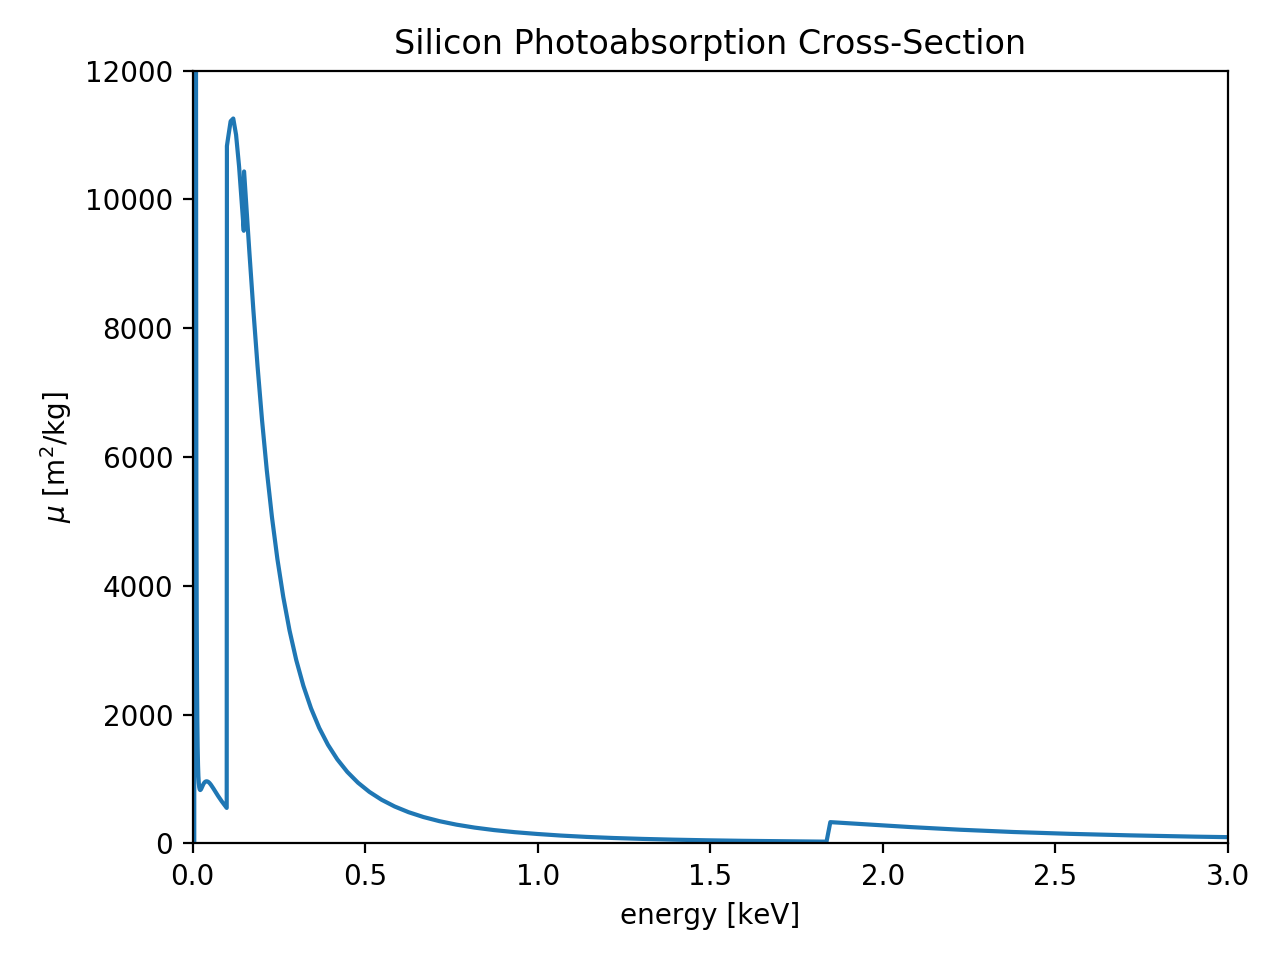

In [3]:
pkl_file = open('data/ffast.pkl', 'rb')
ffast = pickle.load(pkl_file)
pkl_file.close()

Z = 14
print(f"Edges of {ffast[Z]['element']}:")
for key in ffast[Z]['edges']:
      print(f"{key:3s}: {ffast[Z]['edges'][key]/1e3:.3f} keV")
plt.figure()
plt.plot(ffast[Z]['E']/1000., ffast[Z]['photoabsorption']*0.1)
plt.xlim(0,3)
plt.ylim(0,1.2e4)
            
plt.xlabel('energy [keV]')
plt.ylabel('$\mu$ [m$^2$/kg]')
plt.title('Silicon Photoabsorption Cross-Section')
plt.tight_layout();

# Detector Efficiency
### Absorption
Absorption probability $P(E)$ is related t the mass aborption coefficient  with:

$$ P(E) = I/I_0 =\exp\left[ -(\mu/\rho) * \rho * t\right] = \exp\left[ -\mu* t\right]$$

with
- $I_0$: initial intensity of X-rays
- $I$:  intensity of X-rays after going through thickness $t$
- $\rho$: density of material 
 
### Detector 

The detector response $P_D$ is given by Small et al. as:
Here, we assume the contact to be Al and the dead layer is of course Si like the detector crystal:

$$ \Large 
\begin{align}
P_D = &(\exp(\mu_{Al}(E) *t_{Al} *\rho_{Al})) * (\exp(\mu_{Si}(E) *t_{dead layer} *\varrho_{Si} )) \\
&\times (1- \exp(\mu_{Si}(E) *t_{detector} *\varrho_{Si} ))
\end{align} $$


<IPython.core.display.Javascript object>


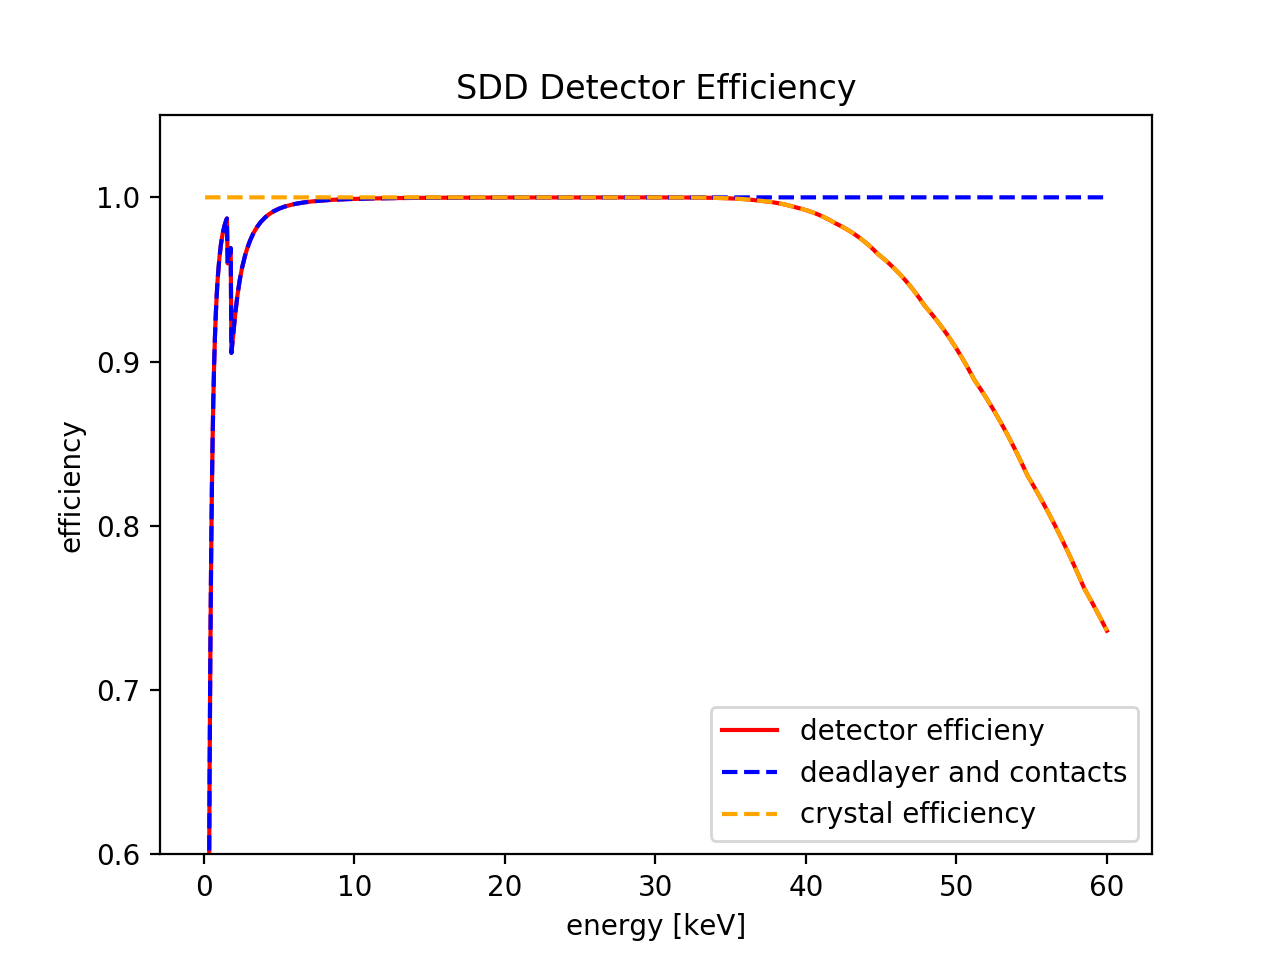

In [4]:
from scipy.interpolate import interp1d
import scipy.constants as const


## layer thicknesses of commen materials in EDS detectors in m
nickelLayer = 0.* 1e-9 # in m
alLayer = 30 *1e-9    # in m
goldLayer = 0.* 1e-9   # in m
deadLayer = 100 *1e-9  # in m
detector_thickness = 45 * 1e-3  # in m

area = 30 * 1e-6 #in m2
oo4pi = 1.0 / (4.0 * np.pi)

#We make a linear energy scale 
energy_scale = np.linspace(.1,60,1199)


## interpolate mass absorption coefficient to our energy scale
lin = interp1d(ffast[14]['E']/1000.,ffast[14]['photoabsorption'],kind='linear') 
mu_Si = lin(energy_scale) * ffast[14]['nominal_density']*100. #1/cm -> 1/m

## interpolate mass absorption coefficient to our energy scale
lin = interp1d(ffast[13]['E']/1000.,ffast[13]['photoabsorption'],kind='linear') 
mu_Al = lin(energy_scale) * ffast[13]['nominal_density'] *100. #1/cm -> 1/m
 
detector_Efficiency1 = np.exp(-mu_Al * alLayer)* np.exp(-mu_Si * deadLayer) 
detector_Efficiency2 = (1.0 - np.exp(-mu_Si * detector_thickness))# * oo4pi;
detector_Efficiency =detector_Efficiency1 * detector_Efficiency2#* oo4pi;

plt.figure()
plt.plot(energy_scale,detector_Efficiency, label = 'detector efficieny', color = 'red')
plt.plot(energy_scale,detector_Efficiency1, '--', label = 'deadlayer and contacts', color = 'blue')
plt.plot(energy_scale,detector_Efficiency2, '--',label = 'crystal efficiency' , color = 'orange')
plt.xlabel('energy [keV]')
plt.ylabel('efficiency')
plt.title('SDD Detector Efficiency')
plt.ylim(0.6,1.05)
plt.legend();

We see that the detector efficiency drops off after our maximum acceleration voltage of 30 keV in the SEM.

The background Bremsstrahlung will be absorbed at low energies as we expected.

Play around with the thickness values of the contact and deadlayer. 

What has the biggest impact?


## Effective Background


<IPython.core.display.Javascript object>


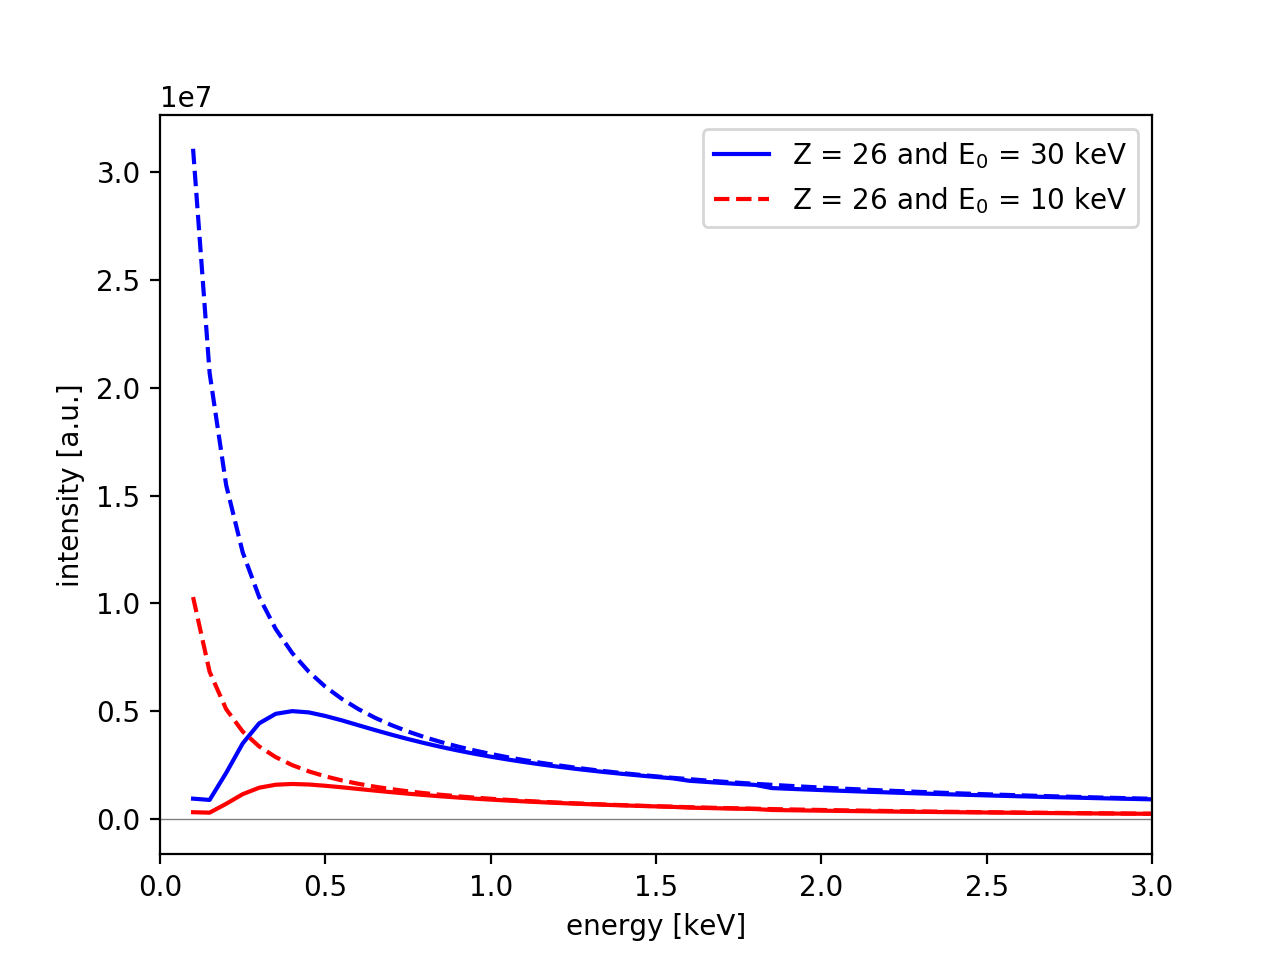

In [5]:
Z = 26
E_0 = 30 # keV

Z2 = 26
E_02 = 10


K = -4000
I = 1
E = energy_scale #= np.linspace(.1,30,2048) #in keV

N_E = I*K*Z*(E-E_0)/E
N_E2 = I*K*Z2*(E-E_02)/E

plt.figure()
plt.plot(energy_scale, N_E, '--', color = 'blue');
plt.plot(energy_scale, N_E*detector_Efficiency , color = 'blue', label = f'Z = {Z} and E$_0$ = {E_0} keV');
plt.plot(energy_scale, N_E2, '--', color = 'red', label = f'Z = {Z2} and E$_0$ = {E_02} keV');
plt.plot(energy_scale, N_E2*detector_Efficiency,  color = 'red');
plt.axhline(y=0., color='gray', linestyle='-', linewidth = 0.5);
plt.xlim(0,3)
plt.legend();

plt.ylabel('intensity [a.u.]')
plt.xlabel('energy [keV]');

In the curve above the change at the lower energiers is now as we expect it.

Please check the slope at about 1.8 keV which is caused by the Si-K edge absorption fo the deadlayer.

Change the values of *Z2* and the acceleration voltage *E_02* of the second curve to see the effects.

## Effect of Window

So far we have ignored the effect of the window in front of the X-ray detector. This window consists mostly of carbon being manufactured from polymer in a modern detector system. The exact composition is necessary to determine the effective background in an EDS spectrum.

<IPython.core.display.Javascript object>


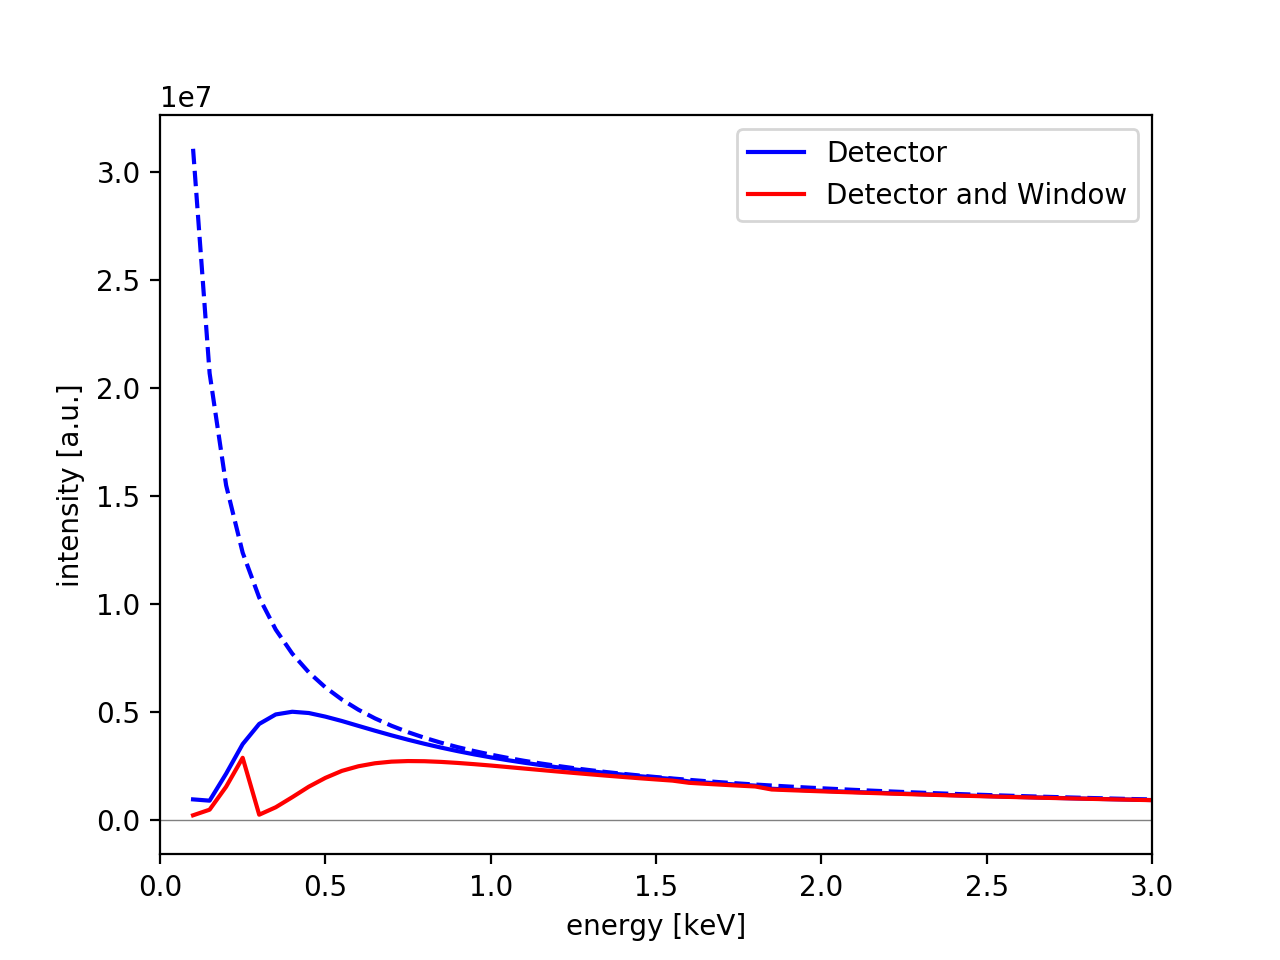

In [6]:
C_window = 300* 1e-9   # in m

## interpolate mass absorption coefficient to our energy scale
lin = interp1d(ffast[6]['E']/1000.,ffast[6]['photoabsorption'],kind='linear') 
mu_C = lin(energy_scale) * ffast[6]['nominal_density']*100. #1/cm -> 1/m


window_Absorption = np.exp(-mu_C * C_window)

plt.figure()
plt.plot(energy_scale, N_E, '--', color = 'blue');
plt.plot(energy_scale, N_E*detector_Efficiency , color = 'blue', label = f'Detector');
plt.plot(energy_scale, N_E*detector_Efficiency * window_Absorption, color = 'red', label = f'Detector and Window');

plt.axhline(y=0., color='gray', linestyle='-', linewidth = 0.5);
plt.xlim(0,3)
plt.legend();

plt.ylabel('intensity [a.u.]')
plt.xlabel('energy [keV]');


## Background Slope at High Energies
While Kramers law gives the approximate shape of the background, the exact slopes is not reproduced.
Several authors intorduced a parametrized function of the Bremsstrahlung efficiency.

<IPython.core.display.Javascript object>


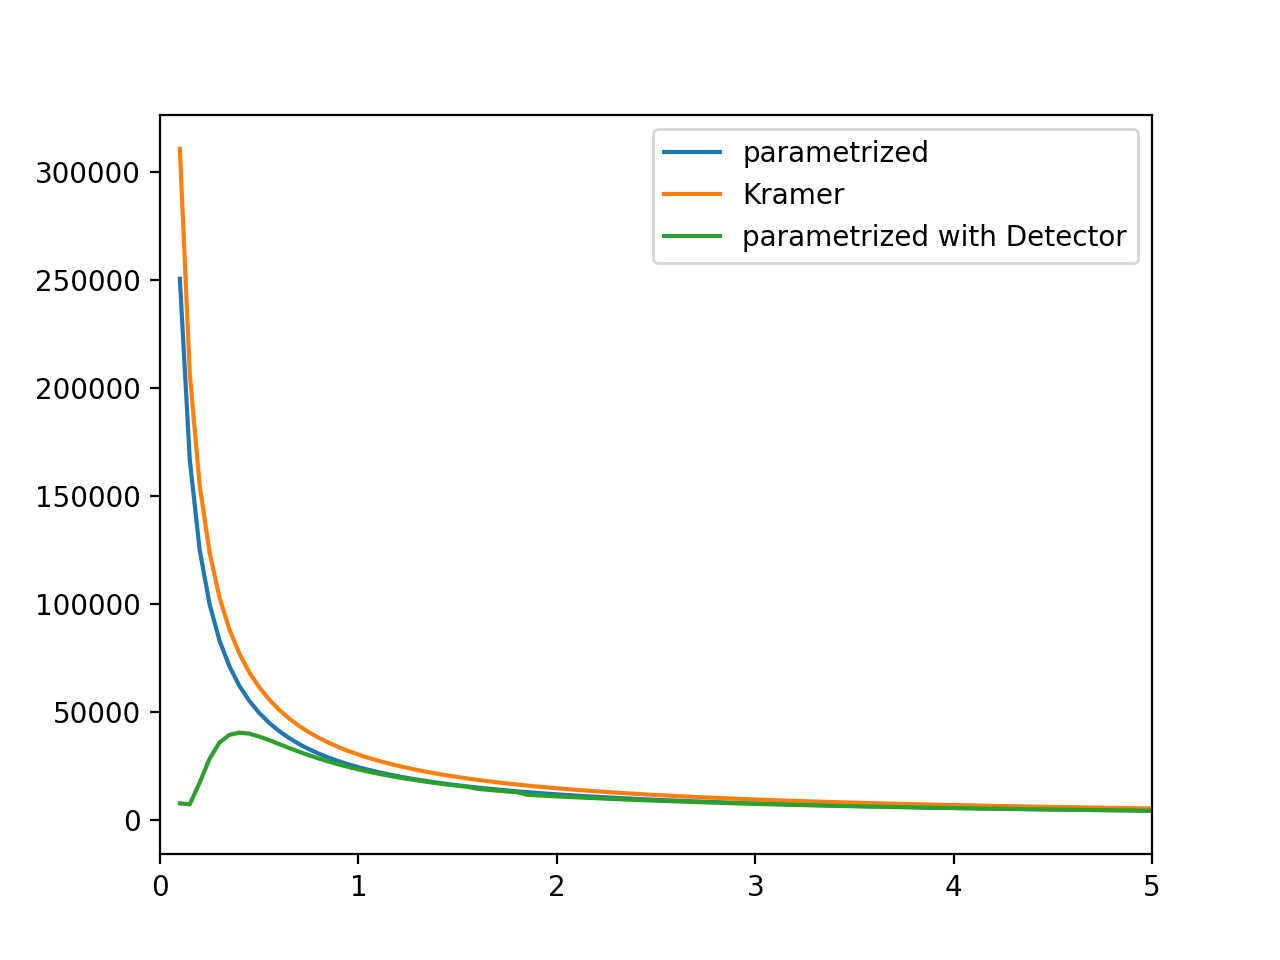

In [9]:
E = energy_scale
Z = 26
E_0 = 30
a = [0, -73.9,1,2446,36.502,148.5, 0.1293,-0.006624,0.0002906]
g  = np.sqrt(Z)* (E_0-E)/E *(a[1]+a[2]*E+a[3]*np.log(Z)+a[4]*E**a[5]/Z)*(1+(a[6]+a[7]*E_0)*Z/E)
plt.figure()

a = [0,54.86,1.072, 0.2835, 30.4,875,-0.08]
g2 = np.sqrt(Z)* (E_0-E)/E *(a[1]+a[2]+a[3]*E_0 +a[4]*np.log(Z)+a[5]*E_0**a[6]/Z**2)
b = [2000,-.6]
f = (b[0]+b[1]*E_0)*Z/E

plt.plot(E,g2, label = 'parametrized')
plt.plot(E,N_E/100, label = 'Kramer')
plt.plot(E,g2*detector_Efficiency,label = 'parametrized with Detector')
plt.xlim(0,5)
plt.legend();

## Fitting Background

Neither Kramer's Law nor any of the parametrized versions of the Bremsstrahlung are usefull for fitting.

The following expression is used for fitting purposes:

$$ N(E) = \epsilon(E) A(E) \left[ p_0+ p_1 \frac{E_0-E}{E} + p_2 \frac{(E_0-E)^2}{E}  \right]$$

in which we have the fitting parameters ($p_0, p_1, p_2$) of a polynomial of the overvoltage.

<IPython.core.display.Javascript object>


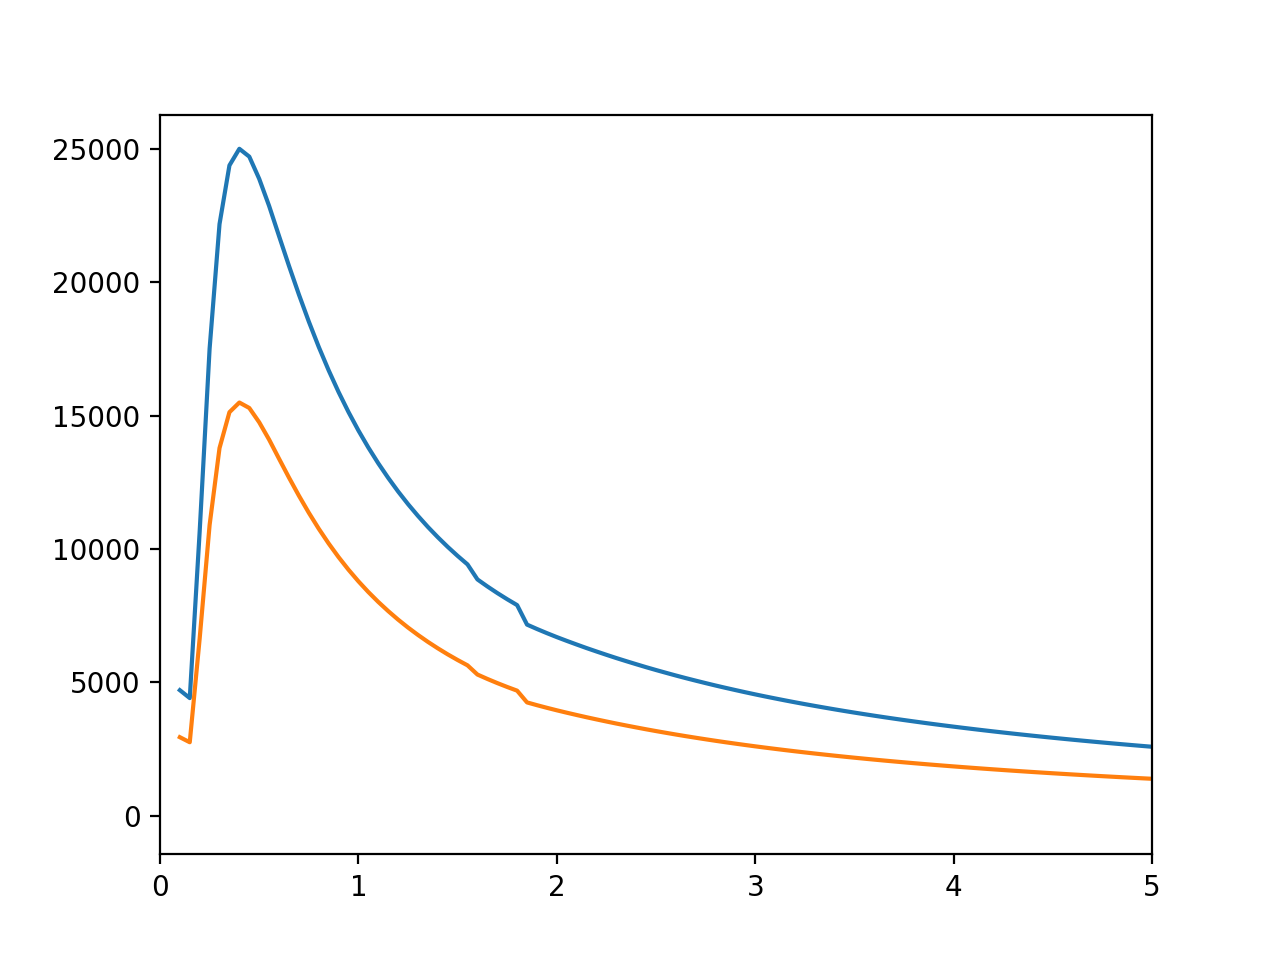

(0, 5)

In [12]:
p = [10, 26, 10]
E = E
N = detector_Efficiency * (p[0] + p[1]*(E_0-E)/E + p[2]*(E_0-E)**2/E)

plt.figure()
plt.plot(E,N_E/200*detector_Efficiency)
plt.plot(E,N)

plt.xlim(0,4)

# Now we put all of that together

and make a function:

The input is in the form of a dictionary.

We note that we have several layers that reduce the efficiency and that the detector crystal itself is not really that importantfor the acceleration voltages in an SEM.


<IPython.core.display.Javascript object>


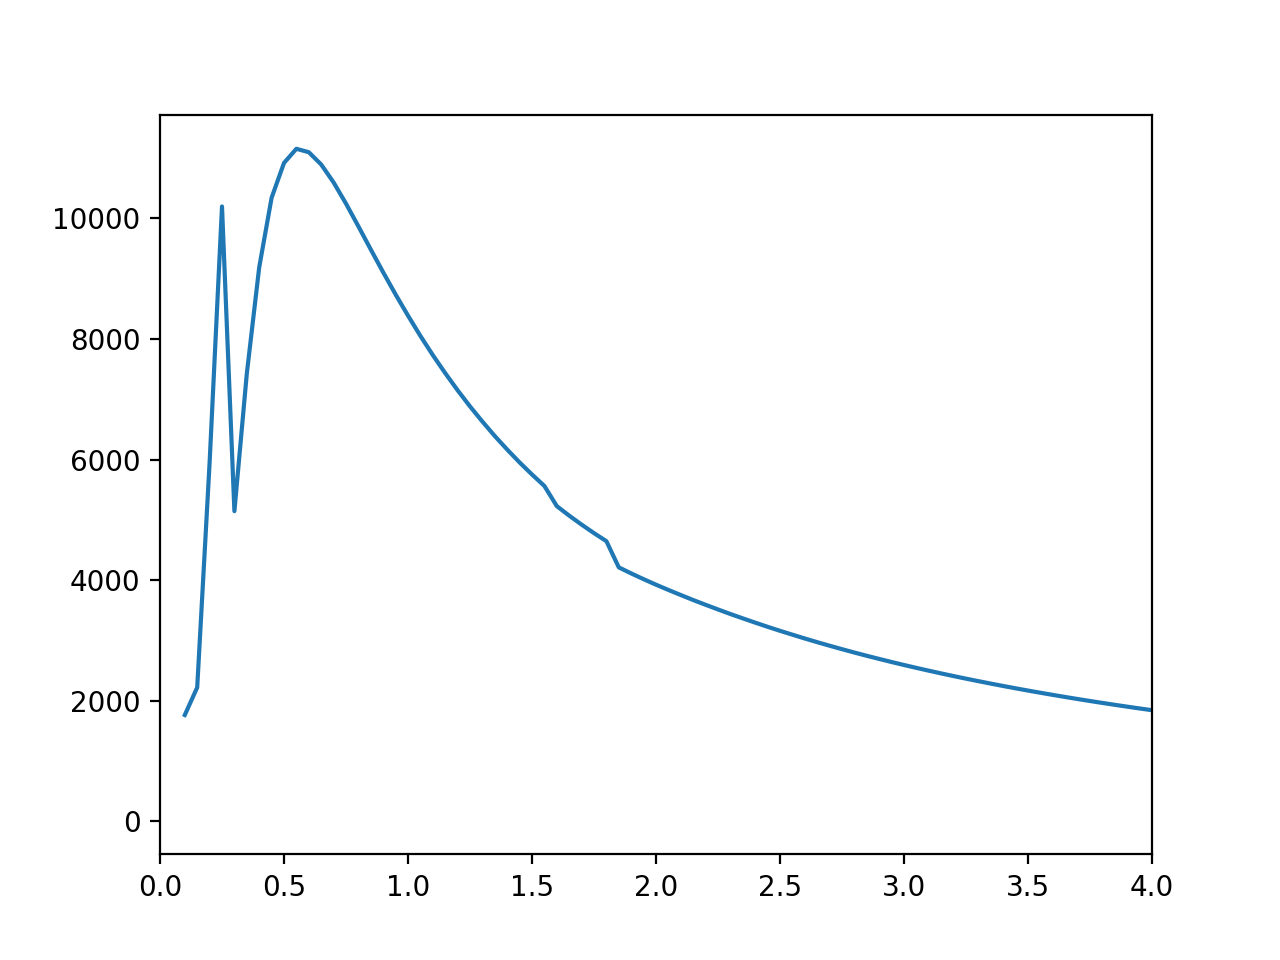

(0, 4)

In [13]:
tags = {}

tags['acceleration_voltage_V'] = 30000

tags['detector'] ={}
tags['detector']['layers'] ={}

## layer thicknesses of commen materials in EDS detectors in m
tags['detector']['layers']['alLayer'] = {}
tags['detector']['layers']['alLayer']['thickness'] = 30 *1e-9    # in m
tags['detector']['layers']['alLayer']['Z'] = 13

tags['detector']['layers']['deadLayer'] = {}
tags['detector']['layers']['deadLayer']['thickness'] =  100 *1e-9  # in m
tags['detector']['layers']['deadLayer']['Z'] = 14

tags['detector']['layers']['window'] = {}
tags['detector']['layers']['window']['thickness'] =  100 *1e-9  # in m
tags['detector']['layers']['window']['Z'] = 6

tags['detector']['detector'] = {}
tags['detector']['detector']['thickness'] = 45 * 1e-3  # in m
tags['detector']['detector']['Z'] = 14
tags['detector']['detector']['area'] = 30 * 1e-6 #in m2
## interpolate mass absorption coefficient to our energy scale


def detector_response(detector_definition,energy_scale):
    response = np.ones(len(energy_scale))
    for key in detector_definition['layers']:
        Z = detector_definition['layers'][key]['Z']
        t = detector_definition['layers'][key]['thickness']
        
        lin = interp1d(ffast[Z]['E']/1000.,ffast[Z]['photoabsorption'],kind='linear') 
        mu = lin(energy_scale) * ffast[Z]['nominal_density']*100. #1/cm -> 1/m
        absorption = np.exp(-mu * t)
        response = response*absorption
    Z = detector_definition['detector']['Z']
    t = detector_definition['detector']['thickness']    
    lin = interp1d(ffast[Z]['E']/1000.,ffast[Z]['photoabsorption'],kind='linear') 
    mu = lin(energy_scale) * ffast[Z]['nominal_density']*100. #1/cm -> 1/m
    response = response*(1.0 - np.exp(-mu * t))# * oo4pi;
    return(response)


p = [10, 26, 10]

def EDS_Background(p,tags,energy_scale):
    E_0= tags['acceleration_voltage_V']/1000

    detector_efficiency = detector_response(tags['detector'],energy_scale)
    E = energy_scale
    N = detector_efficiency * (p[0] + p[1]*(E_0-E)/E + p[2]*(E_0-E)**2/E)
    return N

background = EDS_Background(p,tags,energy_scale)

plt.figure()
plt.plot(energy_scale, background)
plt.xlim(0,4)

## Back: [Characteristic X-Rays](CH4-Characteristic_X_Rays.ipynb)
## Next: [Analyze Spectrum](CH4-Analyze_Spectrum.ipynb)
## List of Content: [Front](_Analysis_of_Scanning_Electron_Microscope_Data.ipynb#Content)